In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

In [22]:
# Set the path to the dataset
data_path = sys.path[0] + "/Dataset"

# Get the list of animal categories
categories = os.listdir(data_path)

# Create a list to store the image filenames and labels
data = []
labels = []

# Load the images and labels
for category in categories:
    folder_path = os.path.join(data_path, category)
    for image_filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_filename)
        data.append(image_path)
        labels.append(category)

# Split the data into train and test sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

In [23]:
# Define a function to preprocess the images
def preprocess_image(image_path):
    # Load the image and resize it to (150, 150)
    img = load_img(image_path, target_size=(48, 48))
    # Convert the image to a numpy array
    img_array = img_to_array(img)
    # Scale the pixel values to the range of [0, 1]
    img_array /= 255.0
    img_array = img_array.reshape(128, 54, 1)
    # Return the preprocessed image
    return img_array

In [24]:
# Define a dictionary that maps category strings to integer labels
label_map = {category: i for i, category in enumerate(categories)}

# Load the images and labels
for category in categories:
    folder_path = os.path.join(data_path, category)
    for image_filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_filename)
        data.append(image_path)
        labels.append(label_map[category])

# Convert the integer labels to one-hot encoded vectors
y_train = to_categorical(np.array([label_map[label] for label in train_labels]))
y_test = to_categorical(np.array([label_map[label] for label in test_labels]))

In [25]:
# Preprocess the images in the train set
X_train = np.array([preprocess_image(image_path) for image_path in train_data])
#Preprocess the images in the test set
X_test = np.array([preprocess_image(image_path) for image_path in test_data])

print("done")

done


In [31]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(11285, 128, 54, 1)
(2822, 128, 54, 1)
(11285, 5)
(2822, 5)


In [36]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128,54,1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(categories), activation='softmax'))

In [38]:
#Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
print("start")
#Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

start
Epoch 1/20
353/353 ━━━━━━━━━━━━━━━━━━━━ 196s 516ms/step - accuracy: 0.4388 - loss: 1.2221 - val_accuracy: 0.5858 - val_loss: 1.0840
Epoch 2/20
353/353 ━━━━━━━━━━━━━━━━━━━━ 187s 531ms/step - accuracy: 0.6672 - loss: 0.8862 - val_accuracy: 0.8313 - val_loss: 0.5071
Epoch 3/20
353/353 ━━━━━━━━━━━━━━━━━━━━ 187s 530ms/step - accuracy: 0.8068 - loss: 0.5566 - val_accuracy: 0.8852 - val_loss: 0.3552
Epoch 4/20
353/353 ━━━━━━━━━━━━━━━━━━━━ 188s 532ms/step - accuracy: 0.8676 - loss: 0.3939 - val_accuracy: 0.9029 - val_loss: 0.2845
Epoch 5/20
353/353 ━━━━━━━━━━━━━━━━━━━━ 186s 526ms/step - accuracy: 0.8917 - loss: 0.3101 - val_accuracy: 0.9160 - val_loss: 0.2447
Epoch 6/20
353/353 ━━━━━━━━━━━━━━━━━━━━ 186s 527ms/step - accuracy: 0.9185 - loss: 0.2382 - val_accuracy: 0.9334 - val_loss: 0.2074
Epoch 7/20
353/353 ━━━━━━━━━━━━━━━━━━━━ 190s 538ms/step - accuracy: 0.9297 - loss: 0.1987 - val_accuracy: 0.9369 - val_loss: 0.2042
Epoch 8/20
353/353 ━━━━━━━━━━━━━━━━━━━━ 187s 529ms/step - accuracy: 0.

In [64]:
model.save_weights('model.weights.h5')

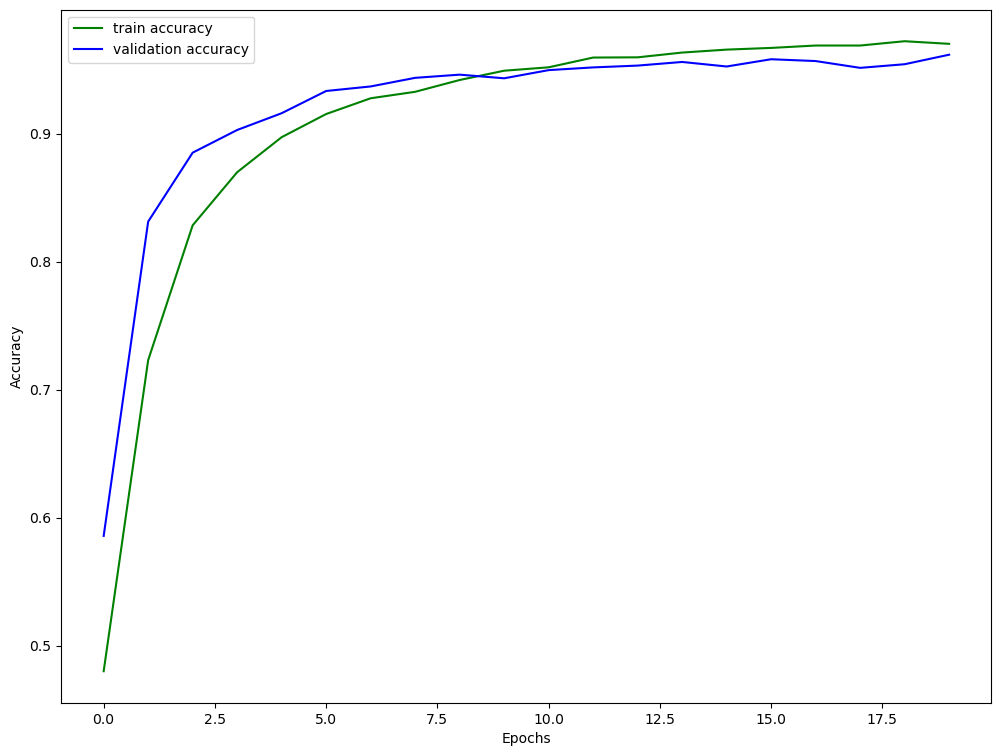

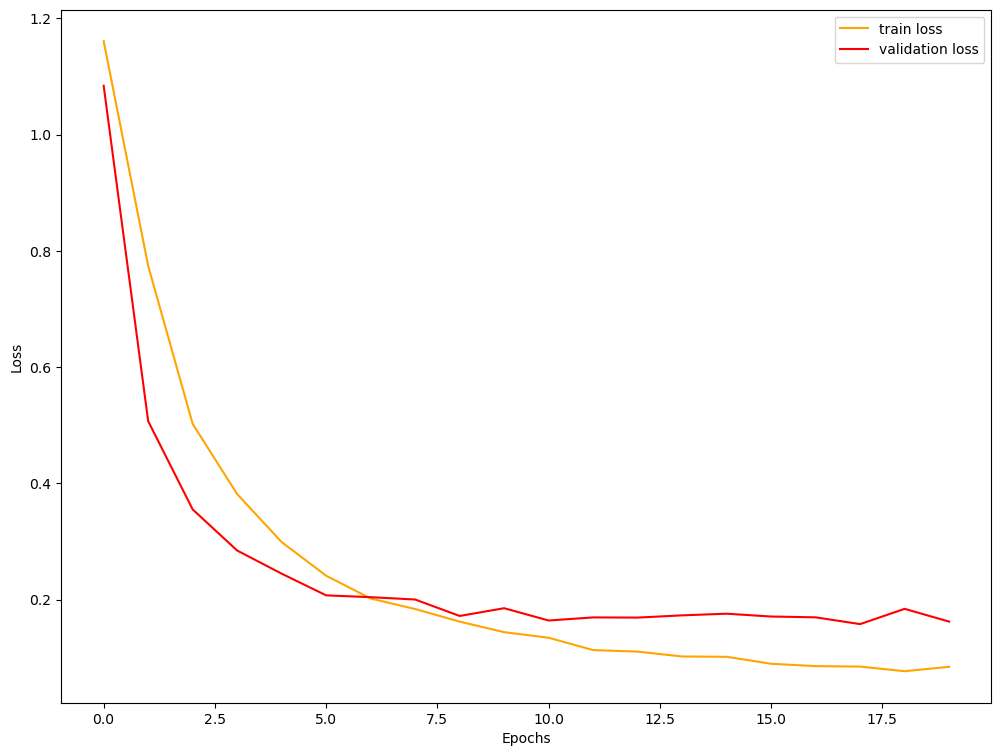

In [66]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']
valid_loss = history.history['val_loss']
valid_acc = history.history['val_accuracy']
def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # accuracy plots
    plt.figure(figsize=(12, 9))
    plt.plot(
        train_acc, color='green', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-', 
        label='validation accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('accuracy.png')
    plt.show()
    # loss plots
    plt.figure(figsize=(12, 9))
    plt.plot(
        train_loss, color='orange', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validation loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('loss.png')
    plt.show()
save_plots(train_acc, valid_acc, train_loss, valid_loss)

In [31]:
def webcamSetup():
    global distr_dict, cap

    # prevents openCL usage and unnecessary logging messages
    cv2.ocl.setUseOpenCL(False)

    # dictionary which assigns each label a state
    distr_dict = {0: "Drinking", 1: "Brushing hair", 2: "Safe driving", 3: "Talking phone", 4: "Texting phone"}
    
    # start the webcam feed
    cap = cv2.VideoCapture(0)

class NoDriverDetectedException(Exception):
    def msg():
        return "No driver detected on the screen"

In [ ]:
def getDistraction():
    # Find haar cascade to draw bounding box around face
    ret, frame = cap.read()
    if not ret:
        return 0
    
    facecasc = cv2.CascadeClassifier(sys.path[0] + '/haarcascade_upperbody.xml')
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = facecasc.detectMultiScale(gray,scaleFactor=1.05, minNeighbors=5)
    
    prediction = 0
    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y-50), (x+w, y+h+10), (255, 0, 0), 2)
        roi_gray = gray[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (54, 128)), -1), 0)
        prediction = model.predict(cropped_img)
    
    data = {}
    if type(prediction) is np.ndarray:
        for distraction in distr_dict:
            data[distr_dict[distraction]] = round(prediction[0][distraction].item(), 5)
    else:
        raise NoDriverDetectedException
    
    return data

In [35]:
from mqtt_wrapper import MQTTWrapper
import json
import sys
import time

def loadUserConfig():
    with open(sys.path[0] + "/userConfig.json") as json_file:
        return json.load(json_file)

client = MQTTWrapper.fromJsonConfig(sys.path[0] + "/mqttConfig.json")
user = loadUserConfig()

webcamSetup()

while True:
    try:
        distractionMap = getDistraction()
        dataToTransmit = { 
            user["user"]: {
                "drinking": distractionMap["Drinking"],
                "brushing_hair": distractionMap["Brushing hair"],
                "safe_driving": distractionMap["Safe driving"],
                "talking_phone": distractionMap["Talking phone"],
                "texting_phone": distractionMap["Texting phone"]
            } 
        }
        client.publish(json.dumps(dataToTransmit))
        print(dataToTransmit)
        time.sleep(1)
    except NoDriverDetectedException:
        print("No driver found!")

    if cv2.waitKey(0) == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 100ms/step
{'person0': {'closed_eyes': 0.0, 'safe_driving': 0.0, 'smoking': 0.0, 'talking_phone': 1.0, 'texting_phone': 0.0, 'turning': 0.0}}
1/1 [==============================] - 0s 16ms/step
{'person0': {'closed_eyes': 0.0, 'safe_driving': 0.0, 'smoking': 0.0, 'talking_phone': 1.0, 'texting_phone': 0.0, 'turning': 0.0}}
1/1 [==============================] - 0s 16ms/step
{'person0': {'closed_eyes': 0.0, 'safe_driving': 0.0, 'smoking': 0.0, 'talking_phone': 1.0, 'texting_phone': 0.0, 'turning': 0.0}}
1/1 [==============================] - 0s 19ms/step
{'person0': {'closed_eyes': 0.0, 'safe_driving': 0.0, 'smoking': 0.0, 'talking_phone': 1.0, 'texting_phone': 0.0, 'turning': 0.0}}
1/1 [==============================] - 0s 20ms/step
{'person0': {'closed_eyes': 0.0, 'safe_driving': 0.0, 'smoking': 0.0, 'talking_phone': 1.0, 'texting_phone': 0.0, 'turning': 0.0}}
1/1 [==============================] - 0s 16ms/step
{'person0': {'closed_eyes': 0.0,

TypeError: 'int' object is not subscriptable